# Kitti数据集的使用方法

参考
https://www.youtube.com/playlist?list=PLDV2CyUo4q-L4YlXUWDytZPz9a8cAWXST


https://github.com/kwea123/ROS_notes


#下載kitti tracking資料並且讀取

资料信息
https://github.com/pratikac/kitti/blob/master/readme.tracking.txt

视频
https://www.youtube.com/watch?v=phyonnkuGbs&list=PLDV2CyUo4q-L4YlXUWDytZPz9a8cAWXST&index=7

In [1]:
import numpy as np
import pandas as pd

# tracking label 的属性
TRACKING_COLUMN_NAMES = ['frame', 'track_id', 'type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top',
                         'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']

def read_tracking(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = TRACKING_COLUMN_NAMES

    # 除去doncare
    df = df[df['track_id']>=0] # remove DontCare objects
    # 所有机动车合并为车
    df.loc[df.type.isin(['Bus', 'Truck', 'Van', 'Tram']), 'type'] = 'Car' # Set all vehicle type to Car
    # 只留下车 行人 自行车
    df = df[df.type.isin(['Car', 'Pedestrian', 'Cyclist'])]
    return df

df = read_tracking("/home/aldno/dataset/2011_09_26/2011_09_26_drive_0005_sync/image_02/tracking/label_02/0000.txt")
# bbox = np.array(df.loc[:, ['bbox_left',	'bbox_top',	'bbox_right',	'bbox_bottom']])
# print(bbox)
df

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,153,10,Car,0,2,-1.818856,680.294919,177.511028,842.313244,284.070033,1.524000,1.728591,3.894227,2.353367,1.622590,12.436503,-1.637280
1085,153,11,Car,0,2,1.864481,245.920800,194.456182,394.817829,286.444967,1.444000,1.595116,3.791789,-5.458963,1.908188,13.979427,1.497916
1086,153,12,Pedestrian,1,0,0.826456,1185.199080,151.165841,1241.000000,348.552707,1.688000,0.800000,0.884000,5.739732,1.500532,6.279632,1.543272
1087,153,13,Car,0,0,1.773993,344.361560,188.772369,430.531955,248.482384,1.422414,1.512803,3.707634,-6.033258,1.888008,19.788795,1.481180


In [3]:
import cv2
# from google.colab.patches import cv2_imshow

COLOR_DICT = {'Car':(255,255,0), 'Cyclist':(255,0,255), 'Pedestrian':(255,55,25)}

frame = 0
image = cv2.imread("/home/aldno/dataset/2011_09_26/2011_09_26_drive_0005_sync/image_02/data/%010d.png"%frame)
boxes = np.array(df[df.frame==0][['bbox_left',	'bbox_top',	'bbox_right',	'bbox_bottom']])
types = np.array(df[df.frame==0]['type'])

for typ, box in zip(types,boxes):
  top_left = int(box[0]),int(box[1])
  bottom_right = int(box[2]),int(box[3])
  cv2.rectangle(image, top_left, bottom_right,COLOR_DICT[typ],2)
# cv2_imshow(image)
cv2.imshow('images', image)

# lidar检测框

![](https://navoshta.com/images/posts/kitti-lidar/pcl_data.gif)

文章
https://navoshta.com/kitti-lidar/

代码
https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb

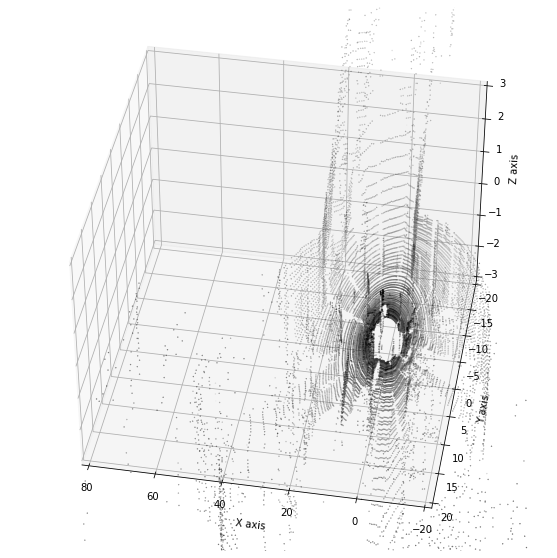

In [4]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_point_cloud(ax, points, axes=[0, 1, 2], point_size = 0.1, xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    axes_limits = [
                   [-20,80],
                   [-20,20],
                   [-3,3]
    ]
    axes_str = ['X','Y','Z']
    ax.grid = False

    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)


points = np.fromfile('/home/aldno/dataset/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data/%010d.bin'%frame,dtype=np.float32).reshape(-1,4)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,100)
draw_point_cloud(ax, points[::5]) #每5个点画一个

## 3d框
同样利用tracking文件，可以提取3d框信息。

The reference point for the 3D bounding box for each object is centered on the
bottom face of the box. 

The corners of bounding box are computed as follows with
respect to the reference point and in the object coordinate system:

```
x_corners = [l/2, l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2]^T
y_corners = [0,   0,    0,    0,   -h,   -h,   -h,   -h  ]^T
z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2  ]^T
```
with l=length, h=height, and w=width.

讲解：https://www.youtube.com/watch?v=H8HGSIi77H0&list=PLDV2CyUo4q-L4YlXUWDytZPz9a8cAWXST&index=12


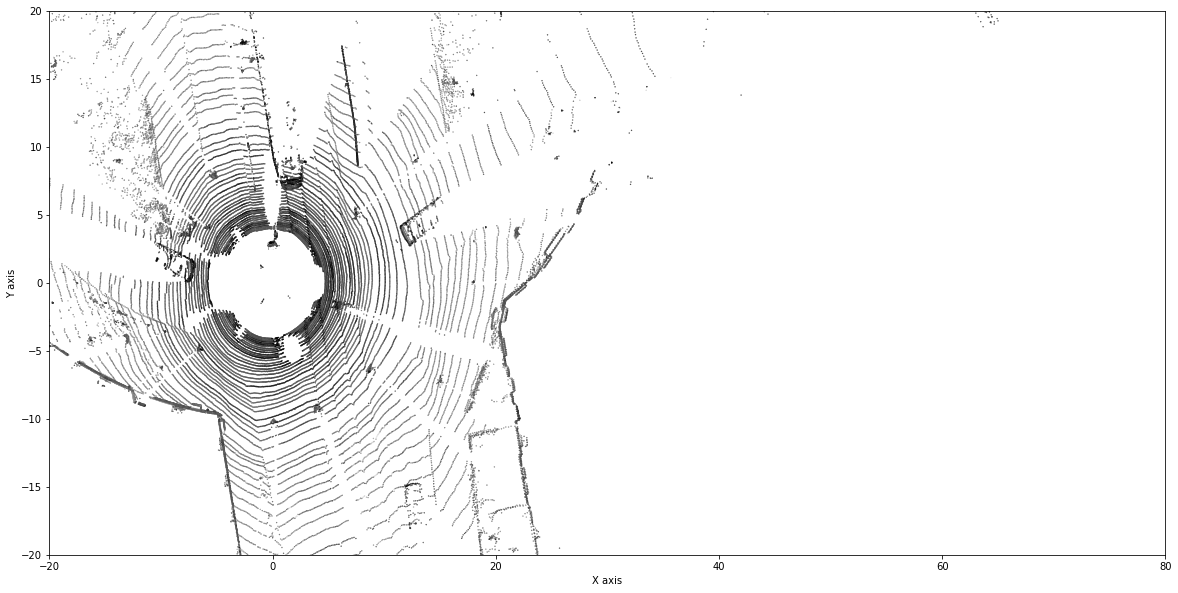

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
draw_point_cloud(ax, points[::2], axes=[0,1]) #鸟瞰

[[-6.48070602 -4.92129955 -2.62386198 -4.18326845 -6.48070602 -4.92129955
  -2.62386198 -4.18326845]
 [ 1.858523    1.858523    1.858523    1.858523   -0.141477   -0.141477
  -0.141477   -0.141477  ]
 [14.83425393 15.77898154 11.98673607 11.04200846 14.83425393 15.77898154
  11.98673607 11.04200846]]


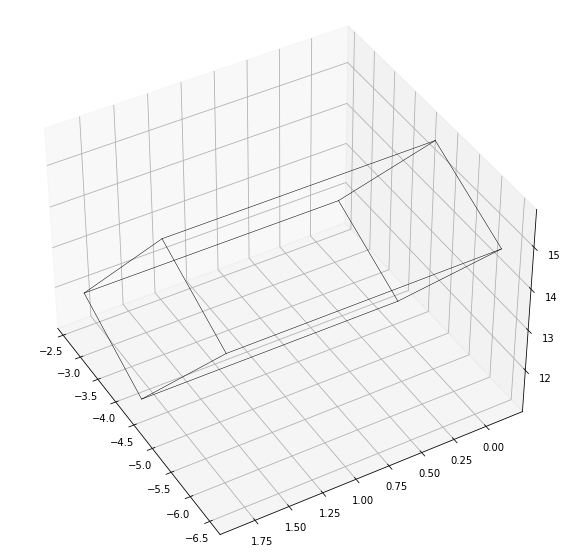

In [11]:
def compute_3d_box_cam2(h, w, l, x, y, z, yaw):
    """
    Return : 3xn in cam2 coordinate
    """
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    corners_3d_cam2[0,:] += x
    corners_3d_cam2[1,:] += y
    corners_3d_cam2[2,:] += z
    return corners_3d_cam2

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

# 照相机坐标系
cornel_3d_cam2 = compute_3d_box_cam2(*df.loc[2,['height','width','length',	'pos_x','pos_y','pos_z','rot_y']])
print(cornel_3d_cam2)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_box(ax, (cornel_3d_cam2)) #每2个点画一个

## 坐标系转换

3d偵測框的數學推導，並在照相機座標系裡將其畫出
另外介紹了calibration(校正)，使的各個座標系之間的點可以自由的進行轉換。我們於是可以把照相機座標系中的3d偵測框投影至velodyne座標系中，並與點雲同時畫出來


代码
https://github.com/charlesq34/frustum-pointnets/blob/master/kitti/kitti_util.py

height          2.0
width      1.823255
length     4.433886
pos_x     -4.552284
pos_y      1.858523
pos_z     13.410495
rot_y     -2.115488
Name: 2, dtype: object


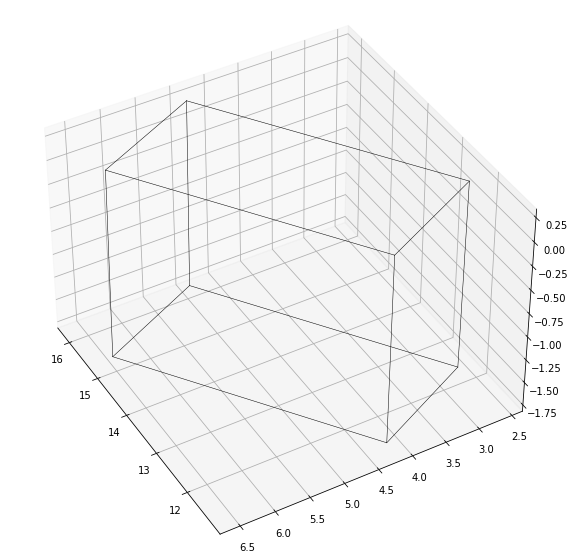

In [15]:
from  kitti_utils  import *

#读取kitti标定文件
calib = Calibration('/home/aldno/dataset/2011_09_26',from_video=True)
# 从2号相机投影到激光传感器坐标系
cornel_3d_velo = calib.project_rect_to_velo(cornel_3d_cam2.T).T
# 画出在激光坐标系下的方框
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_box(ax, (cornel_3d_velo)) #每2个点画一个

## 最终结果

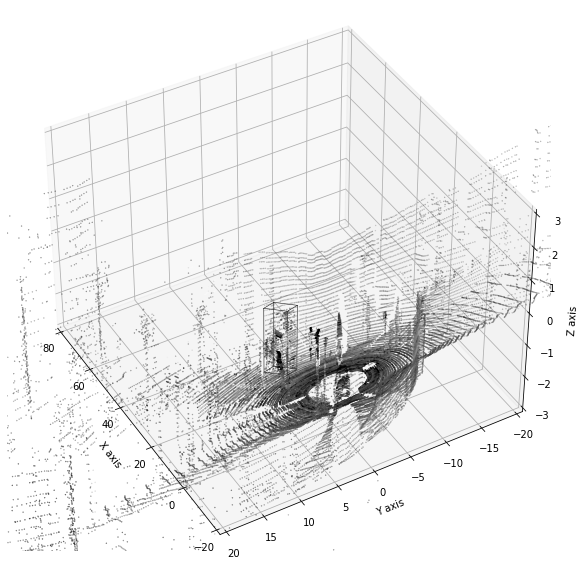

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_point_cloud(ax, points[::2]) #每2个点画一个
draw_box(ax, (cornel_3d_velo)) #每2个点画一个

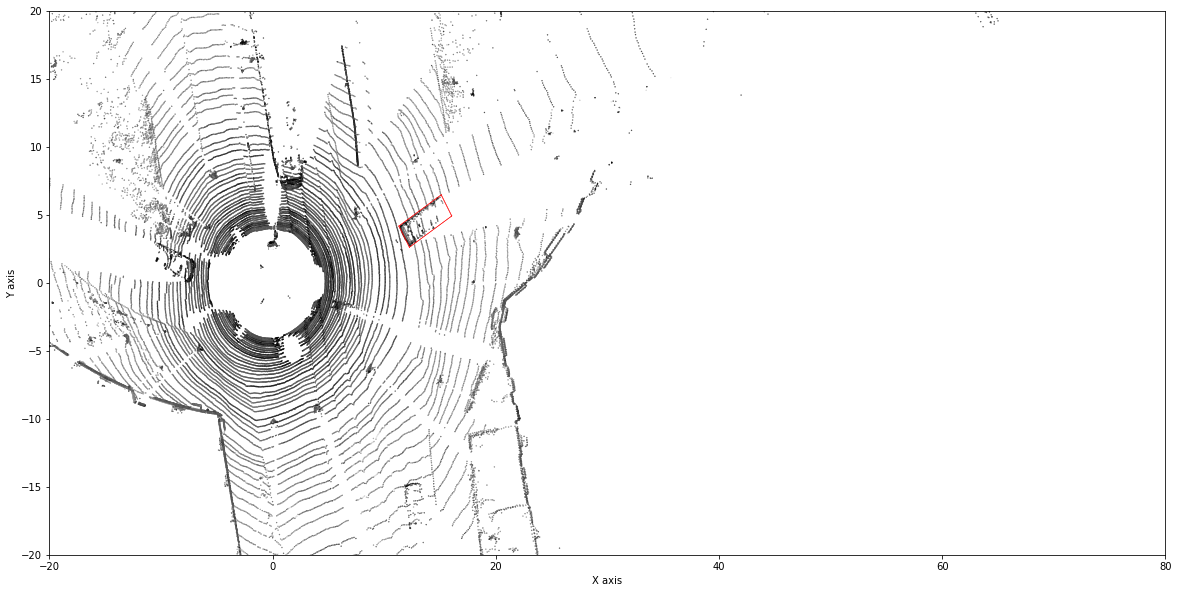

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
draw_point_cloud(ax, points[::2], axes=[0,1]) #鸟瞰
draw_box(ax, (cornel_3d_velo), axes=[0,1], color='r') #每2个点画一个

# 读取IMU GPS信息

oxts文件夹中,数据格式[参考如下](https://github.com/pratikac/kitti/blob/master/readme.raw.txt).

利用IMU/GPS資料計算移動距離以及旋轉角度

- 利用yaw得到旋转角度

- 移動距離有兩種算法
1.利用GPS計算大圓距離
https://zh.wikipedia.org/wiki/%E5%A4%A7%E5%9C%86%E8%B7%9D%E7%A6%BB

2.利用IMU提供的速度乘上經過的時間

在短時間內的話，以IMU資料計算出的結果會具有更高的精確性及平滑性。

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def read_imu(path):
  IMU_COLUMN_NAMES = ['lat', 'lon', 'alt', 'roll', 'pitch', 'yaw', 'vn', 've', 'vf', 'vl', 'vu', 'ax', 'ay', 'az', 'af',
                      'al', 'au', 'wx', 'wy', 'wz', 'wf', 'wl', 'wu', 'posacc', 'velacc', 'navstat', 'numsats', 'posmode',
                      'velmode', 'orimode']

  df = pd.read_csv(path, header=None, sep=' ')
  df.columns = IMU_COLUMN_NAMES
  return df
read_imu('/home/aldno/dataset/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/0000000000.txt')


,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numsats,posmode,velmode,orimode
0,49.011213,8.422885,112.834923,0.022447,0.00001,-1.22191,-3.325632,1.138431,3.514768,0.037625,...,-0.017499,0.021393,0.14563,0.492294,0.068884,4,10,4,4,0


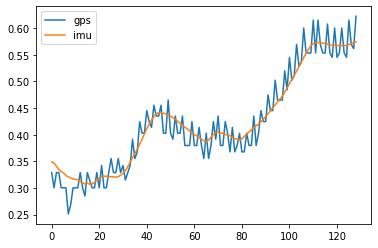

In [9]:
#利用gps计算两帧距离
def compute_great_circle_distance(lat1, lon1, lat2, lon2):
    """
    Compute the great circle distance from two gps data
    Input   : latitudes and longitudes in degree
    Output  : distance in meter
    """
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+ \
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    if np.abs(delta_sigma) > 1:
        return 0.0
    return 6371000.0 * np.arccos(delta_sigma)

# 计算所有
def compute_every_two_frame_distance():
  prev_imu_data = None
  gps_distances = []
  imu_distances = []
  for frame in range(130):
    imu_data = read_imu('/home/aldno/dataset/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)

    if prev_imu_data is not None:
      gps_distances += [compute_great_circle_distance(imu_data.lat, imu_data.lon, prev_imu_data.lat, prev_imu_data.lon)]
      imu_distances += [0.1*np.linalg.norm(imu_data[['vf','vl']])] # 0.1s移动距离
    prev_imu_data = imu_data
  return gps_distances, imu_distances

gps_distances,imu_distances = compute_every_two_frame_distance()
plt.figure()
plt.plot(gps_distances, label='gps')
plt.plot(imu_distances, label='imu')
plt.legend()
plt.show()

## 计算移动轨迹

https://www.youtube.com/watch?v=TEO3dFeIO-8&list=PLDV2CyUo4q-L4YlXUWDytZPz9a8cAWXST&index=16

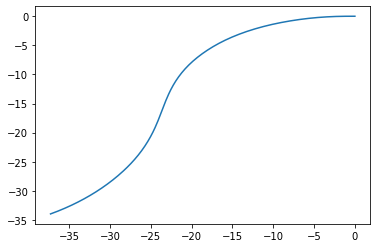

In [ ]:
# 畫出自己所有過去的軌跡
def compute_locations():
  prev_imu_data = None
  locations = []
  for frame in range(130):
    imu_data = read_imu('%010d.txt'%frame)

    if prev_imu_data is not None:
      displacement = [0.1*np.linalg.norm(imu_data[['vf','vl']])] # 0.1s移动距离
      yaw_change = float(imu_data.yaw - prev_imu_data.yaw)
      for i in range(len(locations)):
        x0, y0 = locations[i]
        # 前一帧坐标变换到现在帧坐标
        x1 = x0*np.cos(yaw_change) + y0*np.sin(yaw_change) - displacement
        y1 = -x0*np.sin(yaw_change) + y0*np.cos(yaw_change)
        locations[i] = [x1,y1]

    locations += [[0,0]] #相对自己
    prev_imu_data = imu_data
  return locations

locations = compute_locations()
plt.figure()
plt.plot(np.array(locations)[:,0], np.array(locations)[:,1])

# 计算物体间距离

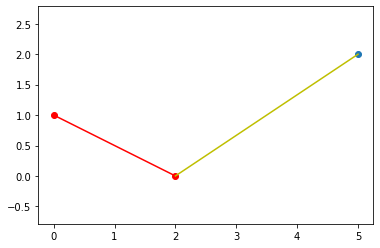

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def distance_point_to_segment(P,A,B):
  """
  calculates the min distance of point P to a segment AB.
  return min distance and point q
  """

  AP = P-A
  BP = P-B
  AB = B-A
  # 锐角，投影点在线段上
  if np.dot(AB,AP)>=0 and np.dot(-AB,BP)>=0:
    return np.abs(np.cross(AP,AB))/np.linalg.norm(AB), np.dot(AP,AB)/np.dot(AB,AB)*AB+A
  # 否则线段外
  d_PA = np.linalg.norm(AP)
  d_PB = np.linalg.norm(BP)
  if d_PA < d_PB:
    return d_PA, A 
  return d_PB, B

P = np.array([5,2],dtype=np.float64) #change Q
A = np.array([0,1],dtype=np.float64)
B = np.array([2,0],dtype=np.float64)

d, Q = distance_point_to_segment(P,A,B)

plt.axes().set_aspect('equal','datalim')
plt.scatter(P[0],P[1])
plt.plot(list(zip(A,B))[0], list(zip(A,B))[1],'r-o')

plt.plot(list(zip(P,Q))[0], list(zip(P,Q))[1],'y-')

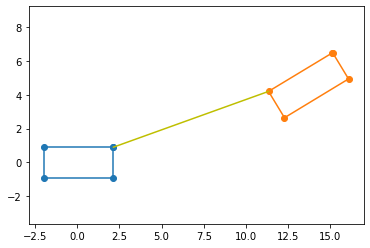

In [2]:
# 计算两个3d框的最短距离

def min_distance_cuboids(cub1,cub2):
  """
  compute min dist between two non-overlapping cuboids of shape (8,4)
  """

  minD = 1e5
  for i in range(4):
    for j in range(4):
      d, Q = distance_point_to_segment(cub1[i,:2], cub2[j,:2], cub2[j+1,:2])
      if d < minD:
        minD = d
        minP = ego_car[i,:2]
        minQ = Q
  for i in range(4):
    for j in range(4):
      d, Q = distance_point_to_segment(cub1[i,:2], cub2[j,:2], cub2[j+1,:2])
      if d < minD:
        minD = d
        minP = corners_3d_velo[i,:2]
        minQ = Q
  return minP, minQ, minD

corners_3d_velo = np.array([
  [15.12424719, 16.06928938, 12.27779014, 11.33274795, 15.10334837, 16.04839056,
  12.25689133, 11.31184914], 
  [ 6.49985556,  4.9406537,  2.64287284,  4.2020747, 6.47872485, 4.91952299,
   2.62174213, 4.18094399],
  [-1.70710774, -1.71370686, -1.7776097,  -1.77101058,  0.29267156,  0.28607244,
   0.2221696,   0.22876872]])

corners_3d_velo = corners_3d_velo.T
ego_car = np.array([[2.15, 0.9, -1.73], [2.15, -0.9, -1.73], [-1.95, -0.9, -1.73],[-1.95,0.9,-1.73], [2.15,0.9,-0.23], [2.15,-0.9,-0.23],[-1.95,-0.9,-0.23],[-1.95,0.9,-0.23]]
                   )

plt.axes().set_aspect('equal','datalim')
plt.plot(ego_car[:5,0],ego_car[:5,1],'-o')
plt.plot(corners_3d_velo[:5,0], corners_3d_velo[:5,1],'-o')
minP,minQ,minD = min_distance_cuboids(ego_car, corners_3d_velo)
plt.plot(list(zip(minP,minQ))[0], list(zip(minP,minQ))[1],'y-')